# **Open Circuit Potential (OCP) Balancing**

This notebook is created to provide an example of using PyBaMM-param package when balancing OCP curve with shifting and stretching the fitted curve to experimental data. This can also be found in `scripts/ocp_balance.py` as Python function.

In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q
import pbparam
import pandas as pd
import os
import matplotlib.pyplot as plt

os.chdir(os.path.join(pbparam.__path__[0], "input", "data"))

We have 4 different files in this example. 2 for half-cell and 2 for three-electrode full cell. They are divided for their lithiation and delithiation stage. Half cell data is Stoichiometry vs Voltage [V] and three-electrode data is Capacity [A.h] vs Voltage [V]. 

In [2]:
#  .csv files are uploaded for Anode
anode_half_lit = pd.read_csv(os.path.join("anode_OCP_2_lit.csv")) # Half cell lithiation data
anode_half_delit = pd.read_csv(os.path.join("anode_OCP_2_delit.csv")) # Half cell delithiation data
anode_three_lit = pd.read_csv(os.path.join("anode_OCP_3_lit.csv")) # three-electrode full cell lithiation data
anode_three_delit = pd.read_csv(os.path.join("anode_OCP_3_delit.csv")) # three-electrode full cell delithiation data

In [3]:
#  .csv files are uploaded for Cathode
cathode_half_lit = pd.read_csv(os.path.join("cathode_OCP_2_lit.csv")) # Half cell lithiation data
cathode_half_delit = pd.read_csv(os.path.join("cathode_OCP_2_delit.csv")) # Half cell delithiation data
cathode_three_lit = pd.read_csv(os.path.join("cathode_OCP_3_lit.csv")) # three-electrode full cell lithiation data
cathode_three_delit = pd.read_csv(os.path.join("cathode_OCP_3_delit.csv")) # three-electrode full cell delithiation data

Let's plot the data to understand better. Even if the starting point of the data needs adjusting as seen in Cathode plot, pbparam is capable of taking the symmetry.

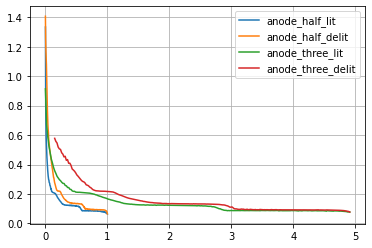

In [4]:
plt.plot(anode_half_lit['Stoichiometry'], anode_half_lit['Voltage [V]'], label='anode_half_lit')
plt.plot(anode_half_delit['Stoichiometry'], anode_half_delit['Voltage [V]'], label='anode_half_delit')
plt.plot(anode_three_lit['Capacity [A.h]'], anode_three_lit['Voltage [V]'], label='anode_three_lit')
plt.plot(anode_three_delit['Capacity [A.h]'], anode_three_delit['Voltage [V]'], label='anode_three_delit')
plt.grid()
plt.legend()

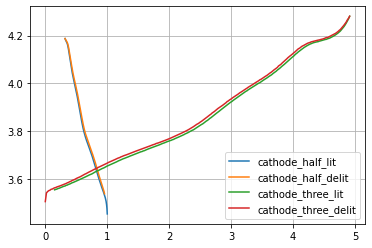

In [5]:
plt.plot(cathode_half_lit['Stoichiometry'], cathode_half_lit['Voltage [V]'], label='cathode_half_lit')
plt.plot(cathode_half_delit['Stoichiometry'], cathode_half_delit['Voltage [V]'], label='cathode_half_delit')
plt.plot(cathode_three_lit['Capacity [A.h]'], cathode_three_lit['Voltage [V]'], label='cathode_three_lit')
plt.plot(cathode_three_delit['Capacity [A.h]'], cathode_three_delit['Voltage [V]'], label='cathode_three_delit')
plt.grid()
plt.legend()

Then, optimisation problem should be passed to pbparam with the data to be used as below. Cost function (default=pbparam.RMSE()) and weights (default=[1,1]) are optional arguments. Weights can be defined as single value list or same lengt with data.

In [6]:
ocp_balance_cathode = pbparam.OCPBalance(
    [cathode_half_lit, cathode_half_delit],
    [cathode_three_lit, cathode_three_delit],
    
    #cost_function=pbparam.MLE(),
    #weights=[2],
)
ocp_balance_cathode.bounds

[<scipy.interpolate.interpolate.interp1d object at 0x13525c040>, <scipy.interpolate.interpolate.interp1d object at 0x135105630>]
Q_V_max is  0.317798093756079
Q_V_min is  1.0


[(-0.5124258667883221, 1.1), (-0.1, 1.612425866788322)]

In [7]:
ocp_balance_anode = pbparam.OCPBalance(
    [anode_half_lit, anode_half_delit],
    [anode_three_lit, anode_three_delit],
    
    #cost_function=pbparam.MLE(),
    #weights=[2],
)
ocp_balance_anode.bounds

[<scipy.interpolate.interpolate.interp1d object at 0x135269130>, <scipy.interpolate.interpolate.interp1d object at 0x135269040>]
Q_V_max is  0.0
Q_V_min is  1.0


[(-1e-06, 1.1), (-0.1, 1.1)]

Optimiser to minimise cost function should be selected in the nest step as below.

In [8]:
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

# optimiser = pbparam.ScipyDifferentialEvolution(
#     extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True})

In [9]:
ocp_balance_cathode.bounds = [(None,None),(None, None)]
ocp_balance_anode.bounds = [(None,None),(None, None)]

```optimiser.optimise(optimisation_problem)``` should be used to run minimasiation algorithm.

In [10]:
result_anode = optimiser.optimise(ocp_balance_anode)
result_cathode = optimiser.optimise(ocp_balance_cathode)

shift and stretch values and final cost function value can be printed as below.

In [11]:
print("Anode Results: ",result_anode)
print("Cathode Results: ",result_cathode)

Anode Results:  
             Optimal values: [-0.02485258  4.85725982]
        Cost function value: 0.5994784773969779
                 Solve time: 120.218 ms
                    Message: Optimization terminated successfully.
        
Cathode Results:  
             Optimal values: [ 6.78447775 -7.09746344]
        Cost function value: 0.003170116930492252
                 Solve time: 170.541 ms
                    Message: Optimization terminated successfully.
        


PyBaMM-param has built in plot function to represent results.

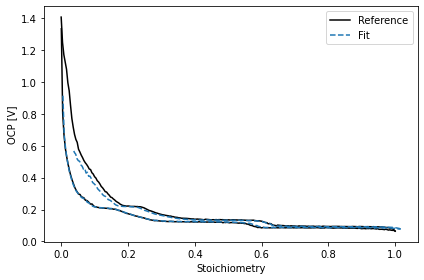

In [12]:
result_anode.plot();

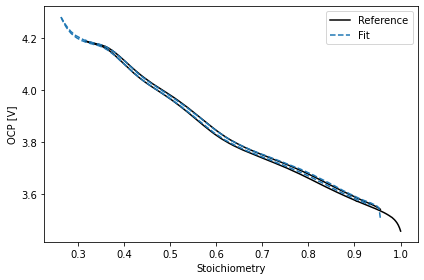

In [13]:
result_cathode.plot();